# Packages

In [2]:
import os
import json
import math
# from google.colab import drive
import wave
import pathlib

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd


import tensorflow as tf
from tensorflow.keras import layers, models
import tensorflow.keras as keras

import librosa
import IPython.display as display

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

### Load on audio file

In [3]:
TRAIN_DATASET_PATH = 'Dataset/Train'
TEST_DATASET_PATH = 'Dataset/Test'

train_data_dir = pathlib.Path(TRAIN_DATASET_PATH)
test_data_dir = pathlib.Path(TEST_DATASET_PATH)

In [6]:
SAMPLE_RATE = 16000
DURATION = 2  # in seconds
SAMPLES_PER_AUDIO = SAMPLE_RATE * DURATION

In [7]:
example_audio_path = os.path.join(TRAIN_DATASET_PATH, 'emabega', 'audio #4251.wav')
audio_signal, sample_rate = librosa.load(example_audio_path, sr=SAMPLE_RATE)
audio = wave.open(example_audio_path, 'rb')

In [8]:
number_of_channel = audio.getnchannels()
sample_width = audio.getsampwidth()
frame_rate = audio.getframerate()
number_of_frames = audio.getnframes()

In [9]:
print('Number of channels:', number_of_channel)
print('Sample width:',       sample_width)
print('frame rate:',         frame_rate)
print('Number of frames:',   number_of_frames)
print('Parameters:',         audio.getparams())

Number of channels: 1
Sample width: 2
frame rate: 16000
Number of frames: 20160
Parameters: _wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=20160, comptype='NONE', compname='not compressed')


### Duration of the audio file

In [10]:
duration = librosa.get_duration(y=audio_signal, sr=sample_rate)
print(f"Duration: {duration} seconds")
print(f"Sample Rate: {sample_rate} Hz")

Duration: 1.26 seconds
Sample Rate: 16000 Hz


### Visualize the audio waveform

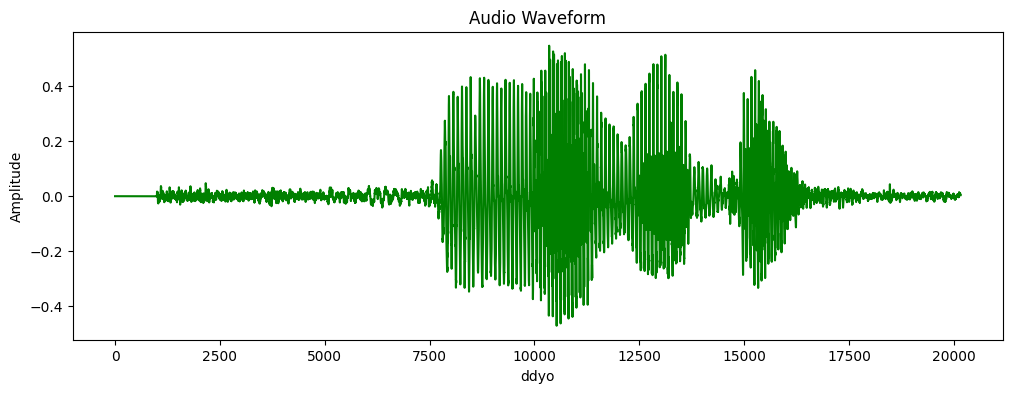

In [11]:
plt.figure(figsize=(12, 4))
plt.plot(audio_signal, color='green')
plt.title('Audio Waveform')
plt.xlabel('ddyo')
plt.ylabel('Amplitude')
plt.show()

### Amplitude Distribution

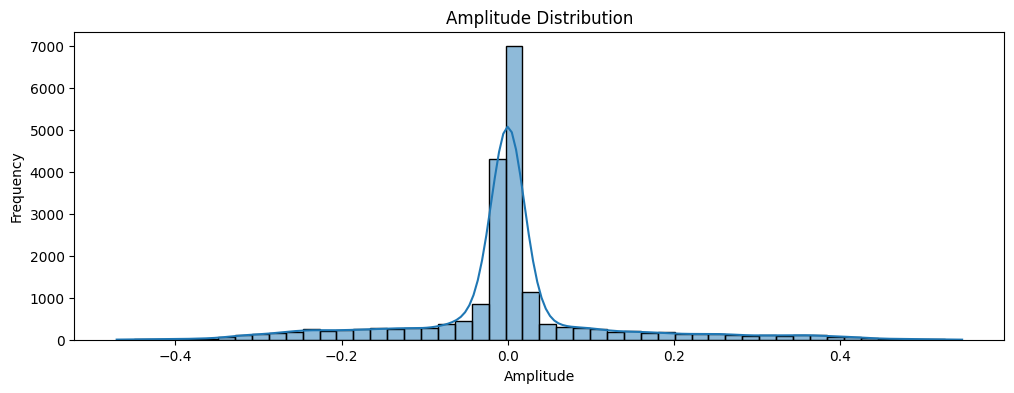

In [12]:
plt.figure(figsize=(12, 4))
sns.histplot(audio_signal, bins=50, kde=True)
plt.title('Amplitude Distribution')
plt.xlabel('Amplitude')
plt.ylabel('Frequency')
plt.show()


In [13]:
audio_stats = pd.DataFrame(audio_signal, columns=['Amplitude'])
print(audio_stats.describe())

          Amplitude
count  20160.000000
mean       0.000009
std        0.121050
min       -0.470551
25%       -0.017738
50%        0.000000
75%        0.013611
max        0.546722


# Preprocess the data

In [14]:
def save_mfcc(dataset_path, json_path, num_mfcc=13, n_fft=2048, hop_length=512, num_segments=6):

    # dictionary to store mapping, labels, and MFCCs
    data = {
        "mapping": [],
        "labels": [],
        "mfcc": []
    }

    samples_per_segment = int(SAMPLES_PER_AUDIO / num_segments)
    num_mfcc_vectors_per_segment = math.ceil(samples_per_segment / hop_length)

    # loop through all sub-folders
    for i, (dirpath, dirnames, filenames) in enumerate(os.walk(dataset_path)):

        # ensure we're processing the sub-folder level
        if dirpath is not dataset_path:

            # save genre label (i.e., sub-folder name) in the mapping
            semantic_label = dirpath.split("/")[-1]
            data["mapping"].append(semantic_label)
            print(f"\nProcessing: {semantic_label}")

            # process all audio files in genre sub-dir
            for f in filenames:

                # load audio file
                file_path = os.path.join(dirpath, f)
                signal, sample_rate = librosa.load(file_path, sr=SAMPLE_RATE)

                # process all segments of audio file
                for d in range(num_segments):

                    # calculate start and finish sample for the current segment
                    start = samples_per_segment * d
                    finish = start + samples_per_segment

                    # extract mfcc
                    mfcc = librosa.feature.mfcc(y=signal[start:finish],
                                                sr=sample_rate,
                                                n_mfcc=num_mfcc,
                                                n_fft=n_fft,
                                                hop_length=hop_length)

                    mfcc = mfcc.T

                    # store only mfcc feature with the expected number of vectors
                    if len(mfcc) == num_mfcc_vectors_per_segment:
                        data["mfcc"].append(mfcc.tolist())
                        data["labels"].append(i-1)
                        print(f"{file_path}, segment:{d+1}")

    # save MFCCs to json file
    with open(json_path, "w") as fp:
        json.dump(data, fp, indent=4)

    # return the data dictionary
    return data


## Save the mfcc data

In [16]:
data = save_mfcc(TRAIN_DATASET_PATH, JSON_PATH, num_segments=6)

NameError: name 'JSON_PATH' is not defined

## Load json file

In [25]:
def load_data(data):

    # convert lists to numpy arrays
    X = np.array(data["mfcc"])
    y = np.array(data["labels"])

    print("Data successfully loaded!")

    return X, y



In [26]:
X, y = load_data(data)

Data successfully loaded!


# Split Data into Training and Testing Sets

In [27]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

# Build a Neural Network Model

In [28]:
model = keras.Sequential([
    keras.layers.Flatten(input_shape=(X.shape[1], X.shape[2])),
    keras.layers.Dense(512, activation='relu', kernel_regularizer=keras.regularizers.l2(0.001)),
    keras.layers.Dropout(0.3),
    keras.layers.Dense(256, activation='relu', kernel_regularizer=keras.regularizers.l2(0.001)),
    keras.layers.Dropout(0.3),
    keras.layers.Dense(64, activation='relu', kernel_regularizer=keras.regularizers.l2(0.001)),
    keras.layers.Dropout(0.3),
    keras.layers.Dense(10, activation='softmax')
])

## Compile the model

In [29]:
optimiser = keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=optimiser,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])


model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 143)               0         
                                                                 
 dense (Dense)               (None, 512)               73728     
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 256)               131328    
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_2 (Dense)             (None, 64)                16448     
                                                                 
 dropout_2 (Dropout)         (None, 64)                0

## Train the Model

In [30]:
history = model.fit(X_train,
                    y_train,
                    validation_data=(X_test, y_test),
                    batch_size=32,
                    epochs=50)

Epoch 1/50
382/382 [==============================] - 10s 16ms/step - loss: 28.8232 - accuracy: 0.1583 - val_loss: 2.9266 - val_accuracy: 0.1696
Epoch 2/50
382/382 [==============================] - 6s 15ms/step - loss: 4.5698 - accuracy: 0.1633 - val_loss: 2.8948 - val_accuracy: 0.1661
Epoch 3/50
382/382 [==============================] - 6s 15ms/step - loss: 3.3319 - accuracy: 0.1654 - val_loss: 2.8650 - val_accuracy: 0.1661
Epoch 4/50
382/382 [==============================] - 4s 11ms/step - loss: 3.0504 - accuracy: 0.1689 - val_loss: 2.8376 - val_accuracy: 0.1661
Epoch 5/50
382/382 [==============================] - 3s 8ms/step - loss: 2.9524 - accuracy: 0.1661 - val_loss: 2.8109 - val_accuracy: 0.1661
Epoch 6/50
382/382 [==============================] - 3s 8ms/step - loss: 2.8913 - accuracy: 0.1659 - val_loss: 2.7850 - val_accuracy: 0.1661
Epoch 7/50
382/382 [==============================] - 6s 15ms/step - loss: 2.8274 - accuracy: 0.1670 - val_loss: 2.7595 - val_accuracy: 0.1661

## History

In [31]:
def plot_history(history):

    fig, axs = plt.subplots(2)

    # create accuracy sublpot
    axs[0].plot(history.history["accuracy"], label="train accuracy")
    axs[0].plot(history.history["val_accuracy"], label="test accuracy")
    axs[0].set_ylabel("Accuracy")
    axs[0].legend(loc="lower right")
    axs[0].set_title("Accuracy eval")

    # create error sublpot
    axs[1].plot(history.history["loss"], label="train error")
    axs[1].plot(history.history["val_loss"], label="test error")
    axs[1].set_ylabel("Error")
    axs[1].set_xlabel("Epoch")
    axs[1].legend(loc="upper right")
    axs[1].set_title("Error eval")

    plt.show()

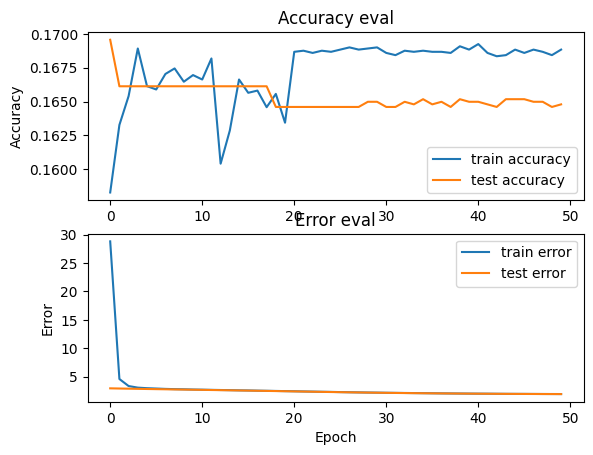

In [32]:
plot_history(history)

## Evaluate the Model

In [33]:
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=2)
print(f'\nTest accuracy: {test_acc}')
print(f'\nTest loss: {test_loss}')

164/164 - 0s - loss: 1.9139 - accuracy: 0.1648 - 446ms/epoch - 3ms/step

Test accuracy: 0.16478900611400604

Test loss: 1.9139403104782104


### Make Predictions

In [34]:
predictions = model.predict(X_test)

164/164 [==============================] - 1s 3ms/step


### Extract label names from the data dictionary

In [35]:
label_names = data["mapping"]

### Plot confusion matrix for test set## Plot confusion matrix for test set


In [36]:
def plot_confusion_matrix(y_true, y_pred, label_names):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, xticklabels=label_names, yticklabels=label_names, annot=True, fmt='g')
    plt.xlabel('Prediction')
    plt.ylabel('Label')
    plt.title('Confusion Matrix')
    plt.show()


164/164 [==============================] - 1s 4ms/step


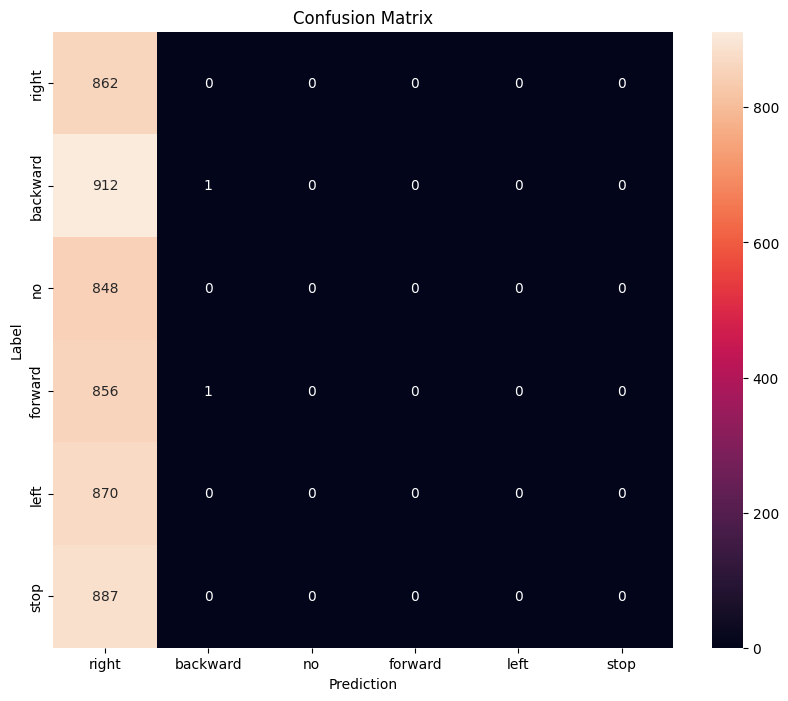

In [37]:
y_pred = model.predict(X_test[..., tf.newaxis])
y_pred = np.argmax(y_pred, axis=1)
plot_confusion_matrix(y_test, y_pred, label_names)

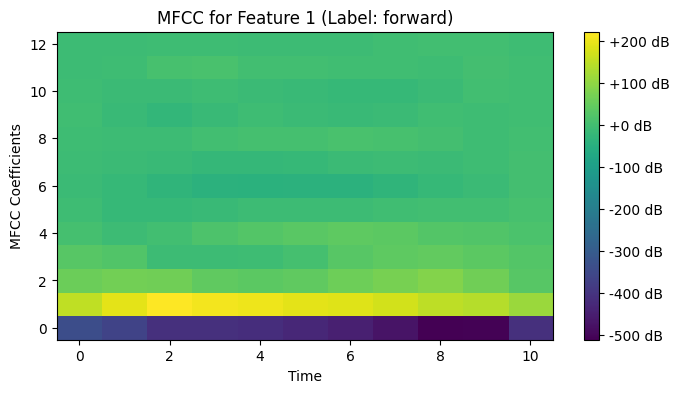

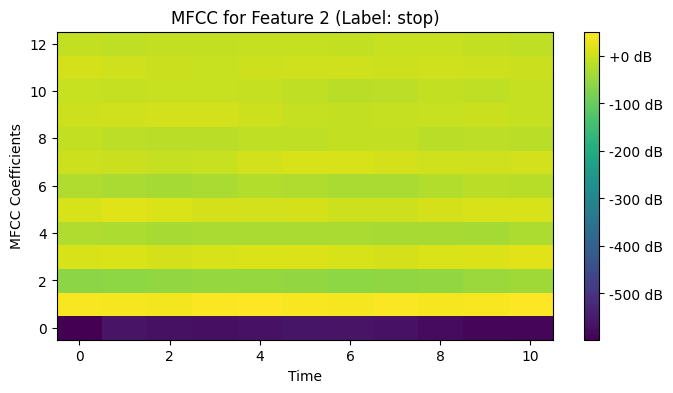

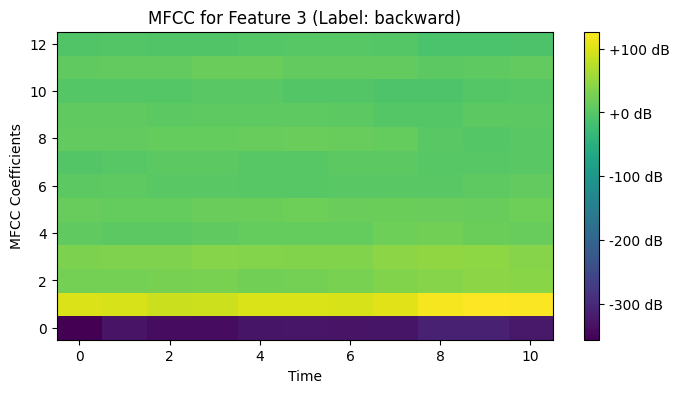

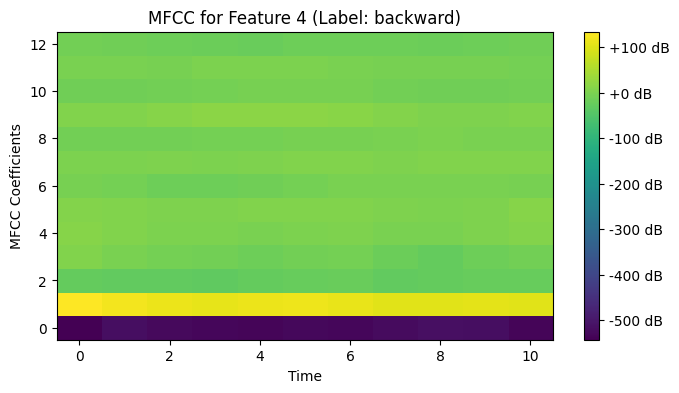

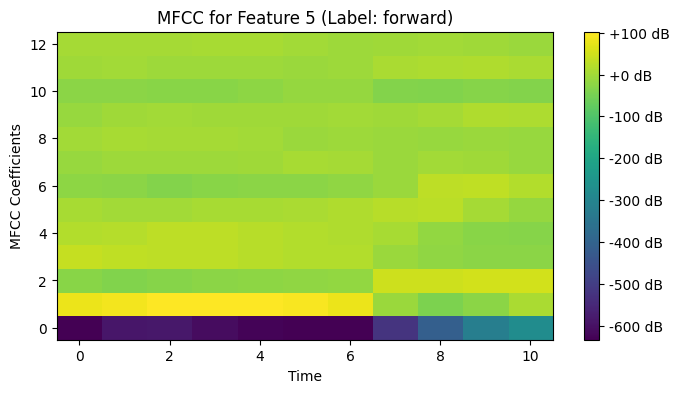

In [38]:
num_features_to_display = 5
for i in range(num_features_to_display):
    index = np.random.randint(0, len(X_test))
    mfcc_feature = X_test[index]
    label = y_test[index]

    plt.figure(figsize=(8, 4))
    plt.imshow(mfcc_feature.T, cmap='viridis', origin='lower', aspect='auto')
    plt.title(f'MFCC for Feature {i + 1} (Label: {label_names[label]})')
    plt.xlabel('Time')
    plt.ylabel('MFCC Coefficients')
    plt.colorbar(format='%+2.0f dB')
    plt.show()

# Save and Export Model

In [39]:
model.save('audio_model.h5')

/home/vx/Desktop/allenv/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
